# piano-e-competition dataset

- 1567 MIDI files were downloaded from the [official website](http://www.piano-e-competition.com/ecompetition/midiinstructions.asp) and saved into folders named by year, i.e., `piano-e-competition/rendered-dataset/YEAR`.

- For each midi file, [Pianoteq 6](https://www.pianoteq.com/pianoteq6) was used to render it into two corresponding audio files, including pedal and non-pedal version (`FILENAME-p.wav` and `FILENAME-np.wav`).

- Noted that the non-pedal version does not have any pedal data, while the pedal version only has pedal data on the sustain pedal which was mapped from 0-127 to binary cases (0-63 as pedall off, 64-127 as pedal on).

- Statistics info for each folder:
    - `2002`: 122 filenames
    - `2004`: 294 filenames
    - `2006`: 343 filenames
    - `2008`: 302 filenames
    - `2009`: 331 filenames
    - `2011`: 175 filenames

- Lists of filenames by year are saved in `piano-e-competition/pedal-metadata/filename-YEAR.txt`

- Data for train/valid/test obtains a ratio of 0.7/0.2/0.1, i.e., 1113/279/175. Here files in folder `2011` forms the test set. The rest of files were shuffled to form the train/valid set, which was splitted by the python code below:

```
import os
import numpy as np
from sklearn.model_selection import train_test_split

dir_pedal_metadata = './piano-e-competition/pedal-metadata/'

# input for spliting the filename in it as train/valid
txt_filename = 'filename-20024689.txt'
txt_path = os.path.join(dir_pedal_metadata, txt_filename)
filenames = np.genfromtxt(txt_path, dtype=None)

x = y = filenames
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=0)

# output
train_filename = 'train.txt'
train_file_path = os.path.join(dir_pedal_metadata, train_filename)

with open(train_file_path, 'w') as train_file:
    for filename in np.sort(x_train):
        train_file.write(filename+'\n')
        
valid_filename = 'valid.txt'
valid_file_path = os.path.join(dir_pedal_metadata, valid_filename)

with open(valid_file_path, 'w') as valid_file:
    for filename in np.sort(x_valid):
        valid_file.write(filename+'\n')
```

- `piano-e-competition/pedal-metadata/{train, valid, test}.txt` lists `YEAR/FILENAME` line by line, e.g.
```
2002/chan01
2002/cho01
```

# Preprocessing for binary classification task

There are two kinds of datasets created for binary classification saved under `./piano-e-competition/pedal-dataset`.

1. `pedal-onset-dataset`
2. `pedal-segment-dataset`

The first one are consisted of 500ms excerpts that are subsegments from tracks with binary labels (**pedal-onset** and **non-pedal-onset**). From midi files, we can get the timing for pedal onset. An excerpt from the pedal-version wav file consists of 500ms of samples with the pedal onset at the 200ms. An excerpt from the corresponding non-pedal-version wav file will also be saved. Neural network can be then trained as a pedal onset detector. 

Excerpt with/without pedal onset is saved as:

`pedal-onset-dataset/CATEGORY/(non-)pedal-onset/FILENAME-(n)p_NUMBER.wav`

The second one are consisted of longer excerpts played with pedal effect or not (labelled as **pedal-segment** and **non-pedal-segment**). From midi files, we can get pedal onset and offset times, based on which the pedalled subsegments are obtained from pedal-version tracks. The corresponding subsegments from the non-pedal-version tracks will also be saved. Neural network can be then trained to tell us whether an excerpt is playing with/without pedal effect.

Excerpt with/without pedal effect is saved as:

`pedal-segment-dataset/CATEGORY/non-pedal-segment/FILENAME-np_NUMBER.wav`

The excerpt's filename, filepath, label and category for both dataset are saved in csv files at: 
- `./piano-e-competition/pedal-metadata/pedal-onset_vd.csv`
- `./piano-e-competition/pedal-metadata/pedal-segment_vd.csv`

**To decide a length threshold for trimming the excerpt, this can be informed by presenting a distribution of pedalled segment length from all the midi files. **

In [1]:
from __future__ import print_function
from __future__ import division
import os, sys
import numpy as np
import pandas as pd
import pretty_midi
import librosa, librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from global_config import *

Using TensorFlow backend.


Channel-last, i.e., (None, n_freq, n_time, n_ch)


In [65]:
print('Calculating pedalled segment length...')
pedal_lengths = []
years = ['2002','2004','2006','2008','2009','2011']
for year in years:
    print('  {}..'.format(year))
    txt_path = os.path.join(DIR_PEDAL_METADATA,'filename-{}.txt'.format(year))
    filenames = np.genfromtxt(txt_path, dtype=None)

    for filename in filenames:
        midi_path = os.path.join(DIR_RENDERED, '{}.mid'.format(filename))
        
        # get ground truth pedal onset time from midi
        pm = pretty_midi.PrettyMIDI(midi_path)
        pedal_v = []
        pedal_t = []
        for control_change in pm.instruments[0].control_changes:
            if control_change.number == 64:
                pedal_v.append(control_change.value)
                pedal_t.append(control_change.time)
                
        pedal_onset = []
        pedal_offset = []
        for i,v in enumerate(pedal_v):
            if i>0 and v>=64 and pedal_v[i-1]<64:
                pedal_onset.append(pedal_t[i])   
            elif i>0 and v<64 and pedal_v[i-1]>=64:
                pedal_offset.append(pedal_t[i])
        
        pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
        seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
        pedal_offset = pedal_offset[:seg_idxs]
        pedal_onset = pedal_onset[:seg_idxs]
        for seg_idx, offset in enumerate(pedal_offset):
            if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
                correct_pedal_data = True
            elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
                correct_pedal_data = True
            else:
                correct_pedal_data = False
        
        if correct_pedal_data:
            for seg_idx in np.arange(seg_idxs):
                pedal_lengths.append(pedal_offset[seg_idx]-pedal_onset[seg_idx])

print('Done!')

Calculating pedalled segment length...
  2002..
  2004..
  2006..
  2008..
  2009..
  2011..
Done!


Text(0.5,1,u'histogram of pedal lengths')

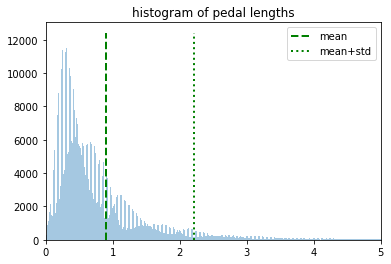

In [67]:
pedal_lengths_mean = np.mean(pedal_lengths)
pedal_lengths_meanplusstd = np.mean(pedal_lengths) + np.std(pedal_lengths)
sns.distplot(pedal_lengths, bins=int(np.max(pedal_lengths)*100), kde=False)
ymin,ymax = plt.ylim()
plt.vlines(pedal_lengths_mean, ymin, ymax, linestyle='dashed', lw=2, color='green',label='mean')
plt.vlines(pedal_lengths_meanplusstd, ymin, ymax, linestyle='dotted', lw=2, color='green',label='mean+std')
plt.xlim(0, 5)
plt.legend()
plt.title('histogram of pedal lengths')

For `pedal-segment-dataset` we decide the excerpts in should obtain a length between:

In [68]:
hist, bin_edges = np.histogram(pedal_lengths, bins=np.arange(0,5,0.1))
print('minimum length: {:.2f} seconds'.format(bin_edges[np.argmax(hist)]))
print('maximum length: {:.2f} seconds'.format(pedal_lengths_meanplusstd))

minimum length: 0.30 seconds
maximum length: 2.22 seconds


We therefore set the value of `MIN_SRC` as 0.3 and `MAX_SRC` as 2.3.

For `pedal-onset-dataset` we decide to set the beginning of the excerpt 0.2s before the pedal onset and 0.3s after. Therefore `TRIM_SECOND_BEFORE` is 0.2 and `TRIM_SECOND_AFTER` is 0.3.

The other global configurations are set in `config.json` and `global_config.py`.

## `config.json` :
```
{
  "dir_rendered": "./piano-e-competition/rendered-dataset",
  "dir_pedal_metadata" : "./piano-e-competition/pedal-metadata",
  "dir_pedal_onset" : "./piano-e-competition/pedal-dataset/pedal-onset-dataset",
  "dir_pedal_segment": "./piano-e-competition/pedal-dataset/pedal-segment-dataset",
  "dir_pedal_onset_npy" : "./piano-e-competition/pedal-dataset/pedal-onset-npydataset",
  "dir_pedal_segment_npy": "./piano-e-competition/pedal-dataset/pedal-segment-npydataset"
  "dir_same_model": "./save-model"
}

```

## `global_config.py`

In [ ]:
"""
import json
from keras import backend as K

if K.image_data_format() == 'channels_first':
    print('Channel-first, i.e., (None, n_ch, n_freq, n_time)')
    channel_axis = 1
    freq_axis = 2
    time_axis = 3
else:
    print('Channel-last, i.e., (None, n_freq, n_time, n_ch)')
    channel_axis = 3
    freq_axis = 1
    time_axis = 2

# Constants
SR = 44100
N_FFT = 1024             # 23 ms
HOP_LENGTH = 10/1000*SR  # 10 ms 
TRIM_SECOND_BEFORE = 0.2
TRIM_SECOND_AFTER = 0.3
ONSET_INPUT_SHAPE = (1, int(SR * (TRIM_SECOND_BEFORE + TRIM_SECOND_AFTER)))
MIN_SRC = 0.3
MAX_SRC = 2.3
LEN_SRC = 2.0
NSP_SRC = int(SR * LEN_SRC)
SEGMENT_INPUT_SHAPE = (1, NSP_SRC)
FOLDERS = ['train', 'valid', 'test']

# Paths
with open('config.json') as json_data:
    config = json.load(json_data)

DIR_RENDERED = config['dir_rendered']
DIR_PEDAL_METADATA = config['dir_pedal_metadata']
DIR_PEDAL_ONSET = config['dir_pedal_onset']
DIR_PEDAL_SEGMENT = config['dir_pedal_segment']
DIR_PEDAL_ONSET_NPY = config['dir_pedal_onset_npy']
DIR_PEDAL_SEGMENT_NPY = config['dir_pedal_segment_npy']
DIR_SAVE_MODEL = config['dir_same_model]

"""

## `main_preprocess.py`

In [ ]:
"""
from __future__ import print_function  # (at top of module)
from __future__ import division
import os
import sys
import argparse
import pandas as pd
import numpy as np
import pretty_midi
import librosa

from global_config import *

def write_to_csv(rows, column_names, csv_fname):
    df = pd.DataFrame(rows, columns=column_names)
    df.to_csv(os.path.join(DIR_PEDAL_METADATA, csv_fname))
    
def prep_pedal_onset():
    """
    Get 500ms excerpts with/without pedal onset at 200ms    
    where pedal onset is obtained from midi file.
    """
    print('Start creating pedal-onset-dataset...')
    filename_segs = []
    filepaths = []
    ys = []
    categories = []
    for folder in FOLDERS:
        print('{}..'.format(folder))
        txt_path = os.path.join(DIR_PEDAL_METADATA,'{}.txt'.format(folder))
        filenames = np.genfromtxt(txt_path, dtype=None)

        pfolder_path = os.path.join(DIR_PEDAL_ONSET, folder, 'pedal-onset/')
        npfolder_path = os.path.join(DIR_PEDAL_ONSET, folder, 'non-pedal-onset/')
        if not os.path.exists(pfolder_path):
            os.makedirs(pfolder_path)
        if not os.path.exists(npfolder_path):
            os.makedirs(npfolder_path)

        for filename in filenames:
            print('  {}..'.format(filename))
            midi_path = os.path.join(DIR_RENDERED, '{}.mid'.format(filename))
            paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
            npaudio_path = os.path.join(DIR_RENDERED, '{}-np.wav'.format(filename))
            paudio, sr = librosa.load(paudio_path, sr=SR)
            npaudio, sr = librosa.load(npaudio_path, sr=SR)

            # get ground truth pedal onset time from midi
            pm = pretty_midi.PrettyMIDI(midi_path)
            pedal_v = []
            pedal_t = []
            for control_change in pm.instruments[0].control_changes:
                if control_change.number == 64:
                    pedal_v.append(control_change.value)
                    pedal_t.append(control_change.time)

            pedal_onset = []
            for i,v in enumerate(pedal_v):
                if i>0 and v>=64 and pedal_v[i-1]<64:
                    pedal_onset.append(pedal_t[i])   

            pedal_onset_sp = librosa.time_to_samples(pedal_onset, sr=SR)

            for seg_idx, sp in enumerate(pedal_onset_sp):
                start_sp = int(sp - TRIM_SECOND_BEFORE * SR)
                end_sp = int(sp + TRIM_SECOND_AFTER * SR)
                newfilename = filename.replace('/','-')

                if start_sp > 0 and end_sp < len(npaudio):
                    pout_name = '{}-p_{}.wav'.format(newfilename, seg_idx)
                    pout_path = os.path.join(pfolder_path, pout_name)            
                    librosa.output.write_wav(pout_path, paudio[start_sp:end_sp], SR)
                    filename_segs.append(pout_name.rstrip('.wav'))
                    filepaths.append(os.path.join(folder, 'pedal-onset/', pout_name))
                    ys.append(1)
                    categories.append(folder)

                    npout_name = '{}-np_{}.wav'.format(newfilename, seg_idx)
                    npout_path = os.path.join(npfolder_path, npout_name)
                    librosa.output.write_wav(npout_path, npaudio[start_sp:end_sp], SR)
                    filename_segs.append(npout_name.rstrip('.wav'))
                    filepaths.append(os.path.join(folder, 'non-pedal-onset/', npout_name))
                    ys.append(0)
                    categories.append(folder)

    write_to_csv(zip(*[filename_segs, filepaths, ys, categories]), 
                 ['filename', 'filepath', 'label', 'category'], 
                 'pedal-onset_vd.csv')
    print('pedal-onset_vd.csv is saved!')
    

def prep_pedal_segment():
    """
    Get varient length excerpts with/without pedal effect    
    where the length is decided by midi file.
    """
    print('Start creating pedal-segment-dataset...')
    filename_segs = []
    filepaths = []
    ys = []
    categories = []
    min_sp = int(MIN_SRC * SR)
    max_sp = int(MAX_SRC * SR)
    for folder in FOLDERS:
        print('{}..'.format(folder))
        txt_path = os.path.join(DIR_PEDAL_METADATA,'{}.txt'.format(folder))
        filenames = np.genfromtxt(txt_path, dtype=None)

        pfolder_path = os.path.join(DIR_PEDAL_SEGMENT, folder, 'pedal-segment/')
        npfolder_path = os.path.join(DIR_PEDAL_SEGMENT, folder, 'non-pedal-segment/')
        if not os.path.exists(pfolder_path):
            os.makedirs(pfolder_path)
        if not os.path.exists(npfolder_path):
            os.makedirs(npfolder_path)

        for filename in filenames:
            print('  {}..'.format(filename))
            # get pedal segment from midi
            midi_path = os.path.join(PATH_DATASET, '{}.mid'.format(filename))
            pm = pretty_midi.PrettyMIDI(midi_path)
            pedal_v = []
            pedal_t = []
            for control_change in pm.instruments[0].control_changes:
                if control_change.number == 64:
                    pedal_v.append(control_change.value)
                    pedal_t.append(control_change.time)

            pedal_onset = []
            pedal_offset = []
            for i,v in enumerate(pedal_v):
                if i>0 and v>=64 and pedal_v[i-1]<64:
                    pedal_onset.append(pedal_t[i])
                elif i>0 and v<64 and pedal_v[i-1]>=64:
                    pedal_offset.append(pedal_t[i])

            pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
            seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
            pedal_offset = pedal_offset[:seg_idxs]
            pedal_onset = pedal_onset[:seg_idxs]
            for seg_idx, offset in enumerate(pedal_offset):
                if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
                    correct_pedal_data = True
                elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
                    correct_pedal_data = True
                else:
                    correct_pedal_data = False

            if correct_pedal_data:
                pedal_onset_sp = librosa.time_to_samples(pedal_onset, sr=SR)
                pedal_offset_sp = librosa.time_to_samples(pedal_offset, sr=SR)
                paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(filename))
                npaudio_path = os.path.join(DIR_RENDERED, '{}-np.wav'.format(filename))
                paudio, sr = librosa.load(paudio_path, sr=SR)
                npaudio, sr = librosa.load(npaudio_path, sr=SR)
                for seg_idx, start_sp in enumerate(pedal_onset_sp):
                    end_sp = pedal_offset_sp[seg_idx]
                    len_sp = end_sp - start_sp
                    if len_sp > max_sp:
                        end_sp = start_sp + max_sp

                    if len_sp >= min_sp and end_sp < len(npaudio):
                        newfilename = filename.replace('/','-')
                        pout_name = '{}-p_{}.wav'.format(newfilename, seg_idx)
                        pout_path = os.path.join(pfolder_path, pout_name)            
                        librosa.output.write_wav(pout_path, paudio[start_sp:end_sp], SR)
                        filename_segs.append(pout_name.rstrip('.wav'))
                        filepaths.append(os.path.join(folder, 'pedal-segment/', pout_name))
                        ys.append(1)
                        categories.append(folder)

                        npout_name = '{}-np_{}.wav'.format(newfilename, seg_idx)
                        npout_path = os.path.join(npfolder_path, npout_name)
                        librosa.output.write_wav(npout_path, npaudio[start_sp:end_sp], SR)
                        filename_segs.append(npout_name.rstrip('.wav'))
                        filepaths.append(os.path.join(folder, 'non-pedal-segment/', npout_name))
                        ys.append(0)
                        categories.append(folder)

    write_to_csv(zip(*[filename_segs, filepaths, ys, categories]), 
                 ['filename', 'filepath', 'label', 'category'], 
                 'pedal-segment_vd.csv')
    print('pedal-segment_vd.csv is saved!')    
    


def print_usage():
    print('This script trims excerpts from origninal audio files and saves them as new wav files.')
    print('$ python main_preprocess.py $dataset_name$')
    print('Example:')
    print('$ python main_preprocess.py pedal-onset-dataset')
    print('$ python main_preprocess.py pedal-segment-dataset')
    print('')
    print('Ps. Make sure you have the rendered dataset already and set the dirs/paths in config.json')
    
    
def main(args):
    dataset_name = args.dataset_name
    if dataset_name == 'pedal-onset-dataset':
        prep_pedal_onset()
    elif dataset_name == 'pedal-segment-dataset':
        prep_pedal_segment()
    else:
        print_usage()


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description = "Preprocess the rendered audio to trim it into excerpts.") 
    parser.add_argument("dataset_name", type=str, help="name of the dataset.")
    main(parser.parse_args()) 
    
"""

Now the excerpts are obtained for each datasets.

### pedal-onset-dataset

1234920 excerpts in total
- 893062 @ /train
- 241670 @ /valid
- 100188 @ /test

duration info (hours/minutes/seconds): 87:31:00 in total
- 2 x 446531 x 0.5 = 124:02:11 (72.32%)
- 2 x 120835 x 0.5 =  33:33:55 (19.57%)
- 2 x  50094 x 0.5 =  13:54:54 ( 8.11%)

### pedal-segment-dataset

983822 excerpts in total
- 707944 @ /train
- 195454 @ /valid
-  80424 @ /test

excerpts are varied in duration (between 0.3-2.3s)

if set 2s as the fixed length then 546:34:04 in total
- 2 x 353972 x 2 = 393:18:08 (71.96%)
- 2 x  97727 x 2 = 108:35:08 (19.87%)
- 2 x  40212 x 2 =  44:40:48 ( 8.17%)

Decode the wav excerpts into fixed length of npy files.

For pedal-onset excerpts, the length are 0.5s.

For pedal-segment excerpts, set the length to 2s. For signals that are shorter than 2s, repeat those signals to create 2-second signals.

## `main_decode.py`

In [ ]:
"""

from __future__ import print_function  # (at top of module)
from __future__ import division
import os
import sys
import argparse
import pandas as pd
import librosa
import numpy as np
import multiprocessing

from global_config import *

def load_save_pedal_onset_npy(track_id):
    """
    Load, decode, and save tracks of pedal onset dataset.
    Load/Save paths are set by `config.json`.
    track_id : integer. e.g. 2
    """
    audio_path = os.path.join(DIR_PEDAL_ONSET,DF_ONSET.loc[[track_id]].filepath.values[0])
    src, _ = librosa.load(audio_path, sr=SR)
    src = src.astype(np.float16)    
    npy_path = os.path.join(DIR_PEDAL_ONSET_NPY,DF_ONSET.loc[[track_id]].filepath.values[0].split('.')[0]+'.npy')
    np.save(npy_path, src)
    
    print('  {}'.format(DF_ONSET.loc[[track_id]].filename.values[0]))


def decode_pedal_onset():
    """
    Decode rendered onset dataset and store them in numpy arrays.
    16-bit Float, SR=44100, and 0.5s
    """
    for folder in FOLDERS:
        print('{}..'.format(folder))

        pfolder_path = os.path.join(DIR_PEDAL_ONSET_NPY, folder, 'pedal-onset/')
        npfolder_path = os.path.join(DIR_PEDAL_ONSET_NPY, folder, 'non-pedal-onset/')
        if not os.path.exists(pfolder_path):
            os.makedirs(pfolder_path)
        if not os.path.exists(npfolder_path):
            os.makedirs(npfolder_path)
            
        tracks_folder = DF_ONSET['category'] == folder
        indices = DF_ONSET.loc[tracks_folder].index

        # decoding
        p = multiprocessing.Pool()
        p.map(load_save_pedal_onset_npy, indices)
        
        
def load_save_pedal_segment_npy(track_id):
    """
    Load, decode, and save tracks of pedal segment dataset.
    Load/Save paths are set by `config.json`.
    track_id : integer. e.g. 2
    """
    audio_path = os.path.join(DIR_PEDAL_SEGMENT,DF_SEGMENT.loc[[track_id]].filepath.values[0])
    src, _ = librosa.load(audio_path, sr=SR, duration=LEN_SRC)
    if len(src) < NSP_SRC:
        tile_times = int(np.ceil(NSP_SRC/len(src)))
        src = np.tile(src, tile_times)[:NSP_SRC]
    else:
        src = src[:NSP_SRC]
    src = src.astype(np.float16)    
    npy_path = os.path.join(DIR_PEDAL_SEGMENT_NPY,DF_SEGMENT.loc[[track_id]].filepath.values[0].split('.')[0]+'.npy')
    np.save(npy_path, src)
    
    print('  {}'.format(DF_SEGMENT.loc[[track_id]].filename.values[0]))


def decode_pedal_segment():
    """
    Decode rendered segment dataset and store them in numpy arrays.
    16-bit Float, SR=44100, and 2s
    """    
    for folder in FOLDERS:
        print('{}..'.format(folder))

        pfolder_path = os.path.join(DIR_PEDAL_SEGMENT_NPY, folder, 'pedal-segment/')
        npfolder_path = os.path.join(DIR_PEDAL_SEGMENT_NPY, folder, 'non-pedal-segment/')
        if not os.path.exists(pfolder_path):
            os.makedirs(pfolder_path)
        if not os.path.exists(npfolder_path):
            os.makedirs(npfolder_path)
            
        tracks_folder = DF_SEGMENT['category'] == folder
        indices = DF_SEGMENT.loc[tracks_folder].index

        # decoding
        p = multiprocessing.Pool()
        p.map(load_save_pedal_segment_npy, indices)
        
        
def print_usage():
    print('This script decode audio excerpts and saves them as npy files.')
    print('$ python main_decode.py $dataset_name$')
    print('Example:')
    print('$ python main_decode.py pedal-onset-dataset')
    print('$ python main_decode.py pedal-segment-dataset')
    print('')
    print('Ps. Make sure you have run the preprocess and set the dirs/paths in config.json')
    
    
def main(args):
    dataset_name = args.dataset_name
    if dataset_name == 'pedal-onset-dataset':
        vd_pedal_onset = os.path.join(DIR_PEDAL_METADATA, 'pedal-onset_vd.csv')
        global DF_ONSET
        DF_ONSET = pd.read_csv(vd_pedal_onset)
        decode_pedal_onset()
    elif dataset_name == 'pedal-segment-dataset':
        vd_pedal_segment = os.path.join(DIR_PEDAL_METADATA, 'pedal-segment_vd.csv')
        global DF_SEGMENT
        DF_SEGMENT = pd.read_csv(vd_pedal_segment)
        decode_pedal_segment()
    else:
        print_usage()
 
    
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description = "Decode audio excerpts and saves them as npy files.") 
    parser.add_argument("dataset_name", type=str, help="name of the dataset.")
    main(parser.parse_args()) 
    
"""

The decoded npy files are saved in `./piano-e-competition/pedal-dataset/`
- `pedal-onset-npydataset/CATEGORY/(non-)pedal-onset/FILENAME-(n)p_NUMBER.npy` 
- `pedal-segment-npydataset/CATEGORY/(non-)pedal-segment/FILENAME-(n)p_NUMBER.npy`.

## Make a small version of the datasets

After generating the excerpts and corresponding npy files, we get the first 70000 training tracks, first 20000 validation tracks and first 10000 test tracks from pedal-onset-dataset and pedal-segment-dataset seperately to form the small version dataset.

In [2]:
def write_to_csv(rows, column_names, csv_fname):
    df = pd.DataFrame(rows, columns=column_names)
    df.to_csv(os.path.join(DIR_PEDAL_METADATA, csv_fname))
    
vd_pedal_onset = os.path.join(DIR_PEDAL_METADATA, 'pedal-onset_vd.csv')
global DF_ONSET
DF_ONSET = pd.read_csv(vd_pedal_onset)
small_vd_pedal_onset_filename = 'pedal-onset_npydf_small.csv'

vd_pedal_segmnet = os.path.join(DIR_PEDAL_METADATA, 'pedal-segment_vd.csv')
global DF_SEGMENT
DF_SEGMENT = pd.read_csv(vd_pedal_segmnet)
small_vd_pedal_segment_filename = 'pedal-segment_npydf_small.csv'

track_categories = ['train', 'valid', 'test']
dfs = [DF_ONSET, DF_SEGMENT]
small_vd_filenames = [small_vd_pedal_onset_filename, small_vd_pedal_segment_filename]

for df,small_vd_filename in zip(dfs, small_vd_filenames):
    filename_segs = []
    filepaths = []
    ys = []
    categories = []
    
    for category in track_categories:
        if category == 'train':
            tracks_n = 70000
        elif category == 'valid':
            tracks_n = 20000
        elif category == 'test':
            tracks_n = 10000
        tracks_category = df['category'] == category
        df_category = df.loc[tracks_category][:tracks_n]
        for row in df_category.itertuples():
            filename_segs.append(row.filename)
            ys.append(row.label)
            categories.append(row.category)
            filepath = row.filepath.split('.')[0]+'.npy'
            filepaths.append(filepath)        

    write_to_csv(zip(*[filename_segs, filepaths, ys, categories]),
                 ['filename', 'filepath', 'label', 'category'], small_vd_filename)